In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import display, HTML

## Data source
https://researchportal.hw.ac.uk/en/datasets/costa-model-hierarchical-carbonate-reservoir-benchmarking-case-st

https://researchportal.hw.ac.uk/en/publications/the-design-of-an-open-source-carbonate-reservoir-model

## Caracteristics of data source

The "COSTA Synthetic Production Monthly" excel file from 5-production provides 30 years of production data from 248 wells. 

While partially synthetic, anonymized, carbonate-specific, from a single hidden-truth field with artificial noise that may not reflect all real-world complexities or reservoir types, it offers significant advantages: 

1. Realistic
2. Well-documented data ideal for learning temporal patterns
3. Testing prediction models without confidentiality concerns.

The truth case ensures consistent, complete, physics-governed data without gaps—more reliable for learning than real data with missing values.

## Target variable: what the economic value of predicting it
Oil Rate SC - Monthly (bbl/day)

Oil rate is the money - predicting which wells will produce more oil directly determines profitability and investment decisions.

## 1º step of data processing: removing yellow headers on each sheet and "charts" sheet

From the file "COSTA Synthetic Production Monthly", we manually create a new file called "final_dataset.xlsx"

We essencially remove the *yellow headers on each sheet* so that python can process the file. Otherwise it is impossible for python to process.

We alsp remove the charts sheet since it is of no use.

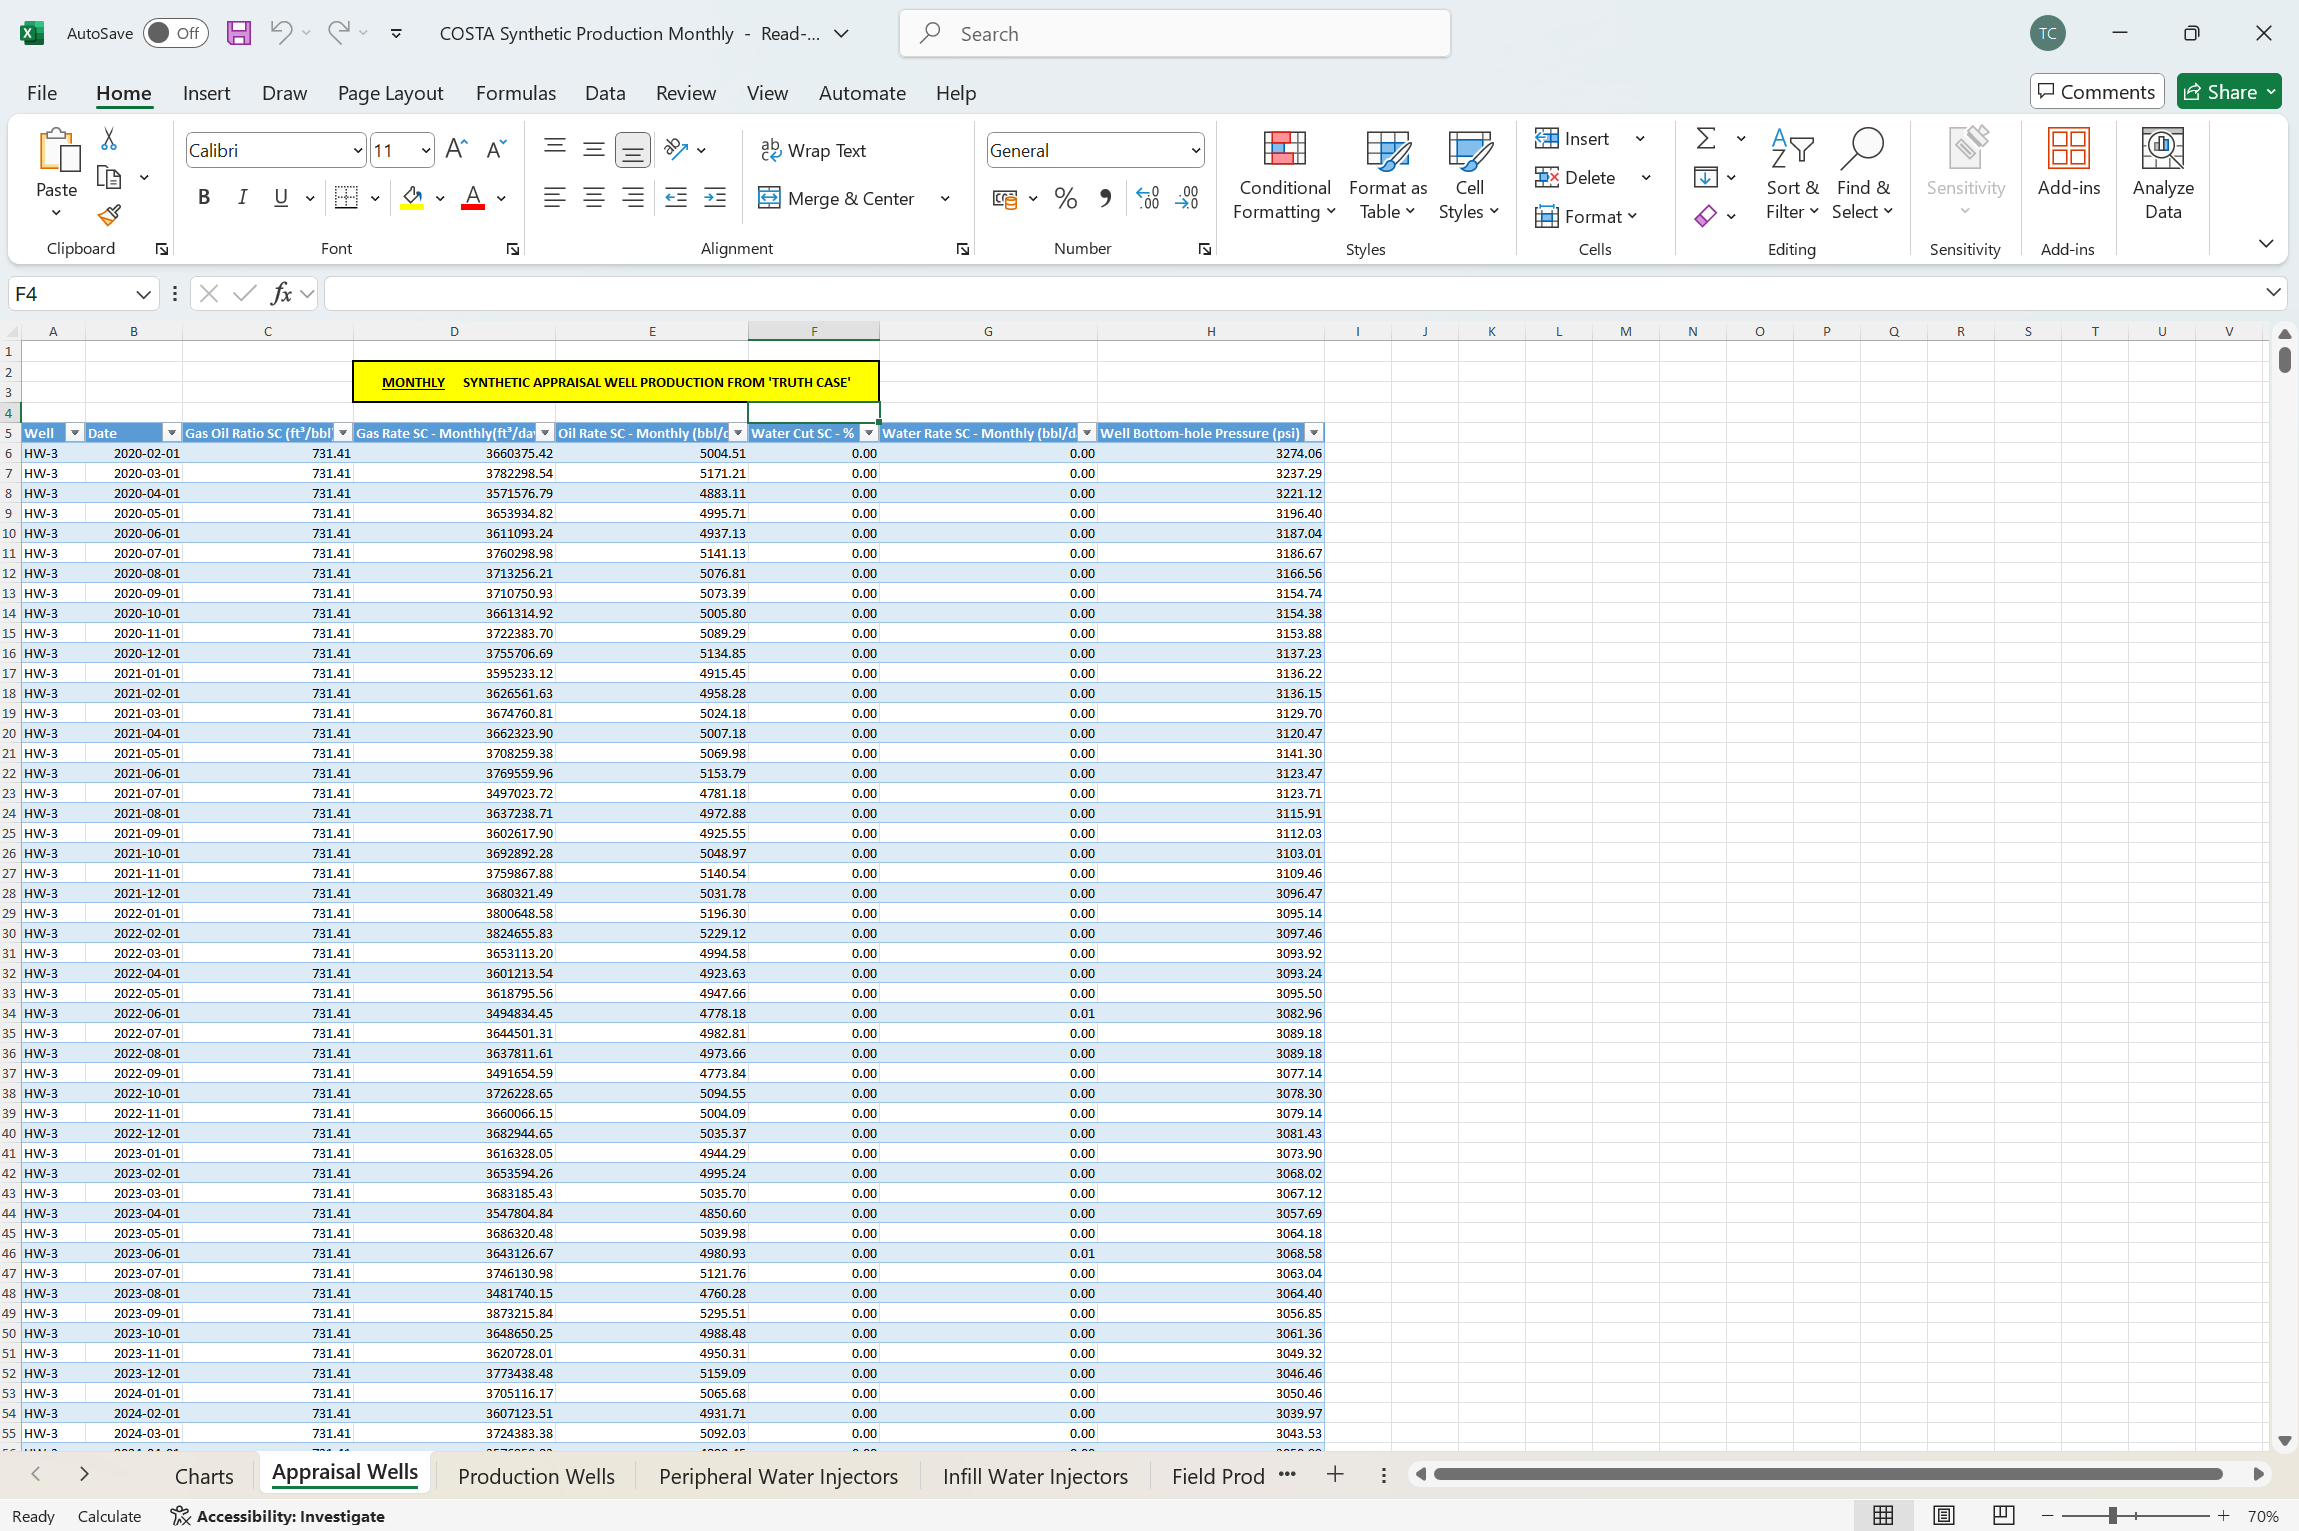

From this, we create a new excel file called final_dataset.xlsx

## 2º step of data processing: Converting the data to be used by a machine learning model

### First we are going to analyse the dataset of Production Wells

In [2]:
excel_file = pd.ExcelFile('final_dataset.xlsx')
all_sheets = {sheet: pd.read_excel(excel_file, sheet_name=sheet) for sheet in excel_file.sheet_names}

df_sheet2 = all_sheets['Production Wells'].iloc[4:]

print(f" Loaded Production Wells data")
print(f"  Total rows: {len(df_sheet2):,}")
print(f"  Total unique wells: {df_sheet2['Well'].nunique()}")

print("Columns:")
for column in list(df_sheet2.columns):
    print(column)

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

For simplification, since it is the one with most data, the production wells sheet is the main one we are going to preprocess to use for the creation of a machine learning model.

### Analyse the data

In [ ]:
print(f"Total unique wells: {df_sheet2['Well'].nunique()}")
print("\nFrequency of frequencies (how many wells appear X times):")
print(df_sheet2['Well'].value_counts().value_counts().sort_index(ascending=False))

It has 8 wells with 300 rows of data

It has 8 wells with 288 rows of data

It has 8 wells with 276 rows of data

.
.
.


It has 20 wells with 120 rows of data


### Create a sliding window function to process all wells informations to be used by an machine learning model

Since the data in each well is distributed by row in a temporal way, we are going to chnage that to be distributed by collumn

This way, we can re format the dataset in a way the machine leatrning model can learn the temporal differences between feature data to better predict the target variable

In [ ]:
WINDOW_SIZE = 12
TARGET_HORIZON = 1

print(f"Window size: {WINDOW_SIZE} months | Target horizon: {TARGET_HORIZON} month ahead\n")

def create_sliding_windows(df, well_name, window_size=12):
    """Create sliding window samples for a single well"""
    df = df.reset_index(drop=True)
    
    if len(df) < window_size + 1:
        return []
    
    samples = []
    for i in range(len(df) - window_size):
        sample = {'Well': well_name, 'Target_Oil_Rate': df.iloc[i + window_size]['Oil Rate SC - Monthly (bbl/day)']}
        
        for month in range(1, window_size + 1):
            for col in df.columns:
                if col != 'Well':
                    sample[f'Month_{month}_{col}'] = df.iloc[i + month - 1][col]
        
        samples.append(sample)
    
    return samples

## We apply the sliding window function to create a new dataset

In [ ]:
all_samples = []
total_wells = df_sheet2['Well'].nunique()

for idx, (well_name, well_data) in enumerate(df_sheet2.groupby('Well'), 1):
    all_samples.extend(create_sliding_windows(well_data, well_name, WINDOW_SIZE))
    
    if idx % 4 == 0:
        print(f"Progress: {idx}/{total_wells} wells ({idx/total_wells*100:.1f}%) - {len(all_samples):,} samples")

print(f"Progress: {total_wells}/{total_wells} wells (100.0%) - {len(all_samples):,} samples total")

## We export the dataset

In [ ]:
df_windowed = pd.DataFrame(all_samples)
cols = ['Well', 'Target_Oil_Rate'] + [c for c in df_windowed.columns if c not in ['Well', 'Target_Oil_Rate']]
df_windowed = df_windowed[cols]

output_filename = 'production_wells_sliding_window.csv'
df_windowed.to_csv(output_filename, index=False)

## Dataset before sliding window

In [ ]:
display(HTML(df_sheet2.head(1000).to_html()))

## Dataset after sliding window

In [ ]:
display(HTML(df_windowed.head(1000).to_html()))

# Training the new machine learning model

In [ ]:
df = pd.read_csv('production_wells_sliding_window.csv')
df = df.drop(columns=[col for col in df.columns if 'Date' in col])
df = df.drop(columns=['Well'])
X = df.drop(columns=['Target_Oil_Rate'])
y = df['Target_Oil_Rate']

print(X.shape)
print(y.shape)

print(X.columns.to_list())

## Calculate and saved in JSON file mean, std(standart deviation) for normalization

In [ ]:
X_mean = X.mean(axis=0).values
X_std = X.std(axis=0).values
y_mean = y.mean()
y_std = y.std()

# Save scaler parameters
scaler_params = {
    "X_scaler": {
        "mean": X_mean.tolist(),
        "std": X_std.tolist(),
        "feature_names": X.columns.tolist()
    },
    "y_scaler": {
        "mean": float(y_mean),
        "std": float(y_std)
    }
}

with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f, indent=2)
print("Scaler parameters saved to scaler_params.json")

## Creating a custom dataset class to pre process the data

The main reason for using a class to take care of the data is to ensure the data and its normalization logic is all together in one reusable object.

The class has 3 methods:
__init__: Sets up the dataset by storing your data and normalization parameters
__len__: Returns how many samples you have (needed by DataLoader)
__getitem__: Gets one normalized sample when requested by index (does the actual normalization)

This is one of the best ways in PyTorch to process data. It is simple and effective

In [ ]:
class RegressionDataset(Dataset):
    def __init__(self, X, y, X_mean, X_std, y_mean, y_std):
        self.X = torch.FloatTensor(X.values if hasattr(X, 'values') else X)
        self.y = torch.FloatTensor(y.values if hasattr(y, 'values') else y)
        self.X_mean = torch.FloatTensor(X_mean)
        self.X_std = torch.FloatTensor(X_std)
        self.y_mean = torch.FloatTensor([y_mean])
        self.y_std = torch.FloatTensor([y_std])
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        #if self.X_std== 0, X normalized does not become Nan it becomes 1e-8
        X_normalized = (self.X[idx] - self.X_mean) / (self.X_std + 1e-8)
        y_normalized = (self.y[idx] - self.y_mean) / (self.y_std + 1e-8)
        return X_normalized, y_normalized

dataset = RegressionDataset(X, y, X_mean, X_std, y_mean, y_std)

### Examples of using the class

#### Using "__len__" special method

In [ ]:
print(f"Dataset size: {len(dataset)}")

#### Using "__getitem__" special method

In [ ]:
X_norm, y_norm = dataset[10]
print(f"Normalized X[0]: {X_norm}")
print(f"Normalized y[0]: {y_norm}")

## Spliting dataset into training, developement(validation) and testing

In [ ]:
total_size = len(dataset)
train_size = int(0.6 * total_size)
dev_size = int(0.2 * total_size)
test_size = total_size - train_size - dev_size

train_dataset, dev_dataset, test_dataset = random_split(
    dataset, 
    [train_size, dev_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

print(f"Train size: {len(train_dataset)}, Dev size: {len(dev_dataset)}, Test size: {len(test_dataset)}")

## Create the dataLoaders

DataLoaders automatically batch, shuffle, and load data in parallel, making it easy to feed data to your model efficiently during training.

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Arquitecture of the AI model

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=2, dropout=0.2, seq_length=12):
        super(LSTM_model, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fully_connected_block = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),  # Added activation between layers
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, 72) - need to reshape to (batch_size, 12, 6)
        batch_size = x.size(0)
        x = x.view(batch_size, self.seq_length, -1)  # (batch_size, 12, 6)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last hidden state
        out = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Fully connected layers
        out = self.fully_connected_block(out)
        
        return out

# Initialize model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM_model(
    input_size=6,      # 6 features per month
    hidden_size=128,   # LSTM hidden units
    num_layers=2,      # Number of LSTM layers
    dropout=0.2,       # Dropout rate
    seq_length=12      # 12 months
).to(device)

### Model architecture and total parameter count

In [ ]:
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

### Parameter names and shapes

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

### Direct children modules

In [ ]:
for name, module in model.named_children():
    print(f"{name}: {module}")

### All modules of the LSTM

In [ ]:
for name, module in model.named_modules():
    print(f"{name}: {module}")

## Hyperparameters, Loss function, optimizer and Learning rate scheduler

In [ ]:
hyperparameters = {
    'learning_rate': 0.00001,
    'batch_size': 64,
    'num_epochs': 15,
    'weight_decay': 1e-5,  # L2 regularization
    'patience': 5,  # For early stopping
    'min_delta': 1e-4  # Minimum improvement for early stopping
}

print("\nHyperparameters:")
for key, value in hyperparameters.items():
    print(f"  {key}: {value}")

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay']
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
)

## Function to train the model

In [ ]:
def train_model(model, train_loader, dev_loader, criterion, optimizer, scheduler, hyperparameters, device):
    num_epochs = hyperparameters['num_epochs']
    patience = hyperparameters['patience']
    min_delta = hyperparameters['min_delta']
    
    best_dev_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    train_losses = []
    dev_losses = []
    
    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70)
    print(f"Device: {device}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(dev_loader.dataset)}")
    print(f"Batches per epoch: {len(train_loader)}")
    print("="*70 + "\n")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        batch_count = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
            batch_count += 1
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        dev_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in dev_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                dev_loss += loss.item() * batch_X.size(0)
        
        dev_loss /= len(dev_loader.dataset)
        dev_losses.append(dev_loss)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Learning rate scheduling
        scheduler.step(dev_loss)
        
        # Print progress every epoch
        print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
              f'Train Loss: {train_loss:.6f} | '
              f'Dev Loss: {dev_loss:.6f} | '
              f'Patience: {patience_counter}/{patience}')
        
        # Early stopping check
        if dev_loss < best_dev_loss - min_delta:
            improvement = best_dev_loss - dev_loss
            best_dev_loss = dev_loss
            best_epoch = epoch + 1
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'> New best model saved | Improvement: {improvement:.6f}\n')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'\n{"="*70}')
            print(f'Early stopping triggered after {epoch+1} epochs')
            print(f'Best model was at epoch {best_epoch} with dev loss: {best_dev_loss:.6f}')
            print("="*70 + "\n")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    print(f'\n{"="*70}')
    print("TRAINING COMPLETED")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Dev Loss: {best_dev_loss:.6f}")
    print(f"Final Train Loss: {train_losses[best_epoch-1]:.6f}")
    print("="*70 + "\n")
    
    return train_losses, dev_losses, best_epoch, best_dev_loss

## Training the model

In [ ]:
train_losses, dev_losses, best_epoch, best_dev_loss = train_model(
    model, train_loader, dev_loader, criterion, optimizer, scheduler, hyperparameters, device
)

### Save training results and hyperparameters in a JSON file

In [ ]:
training_results = {
    "model_architecture": {
        "type": "LSTM",
        "input_size": 6,
        "hidden_size": 128,
        "num_layers": 2,
        "dropout": 0.2,
        "seq_length": 12,
        "total_parameters": sum(p.numel() for p in model.parameters())
    },
    "hyperparameters": hyperparameters,
    "training_info": {
        "device": str(device),
        "train_samples": len(train_loader.dataset),
        "dev_samples": len(dev_loader.dataset),
        "test_samples": len(test_loader.dataset),
        "best_epoch": int(best_epoch),
        "best_dev_loss": float(best_dev_loss),
        "final_train_loss": float(train_losses[best_epoch-1]),
        "total_epochs_trained": len(train_losses),
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    },
    "loss_history": {
        "train_losses": [float(loss) for loss in train_losses],
        "dev_losses": [float(loss) for loss in dev_losses]
    }
}

with open('training_results.json', 'w') as f:
    json.dump(training_results, f, indent=2)

print("Training results and hyperparameters saved to 'training_results.json'")

### Showing a summary of the statistics of the training

In [ ]:
print(f"Best Epoch: {best_epoch}/{len(train_losses)}")
print(f"Best Dev Loss: {best_dev_loss:.6f}")
print(f"Train Loss at Best Epoch: {train_losses[best_epoch-1]:.6f}")
print(f"Improvement from start: {train_losses[0] - train_losses[best_epoch-1]:.6f}")

### Saving the model for future use in production

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': best_epoch,
    'train_loss': train_losses[best_epoch-1],
    'dev_loss': best_dev_loss,
}, 'oil_production_lstm_checkpoint.pth')

print("Model saved to 'oil_production_lstm_checkpoint.pth'")

## Evaluating the best model on the test set

In [ ]:
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        
        # Store normalized predictions and actuals
        all_predictions.append(outputs.cpu())
        all_actuals.append(batch_y.cpu())

# Concatenate all batches
predictions_normalized = torch.cat(all_predictions, dim=0).numpy()
actuals_normalized = torch.cat(all_actuals, dim=0).numpy()

# Denormalize predictions and actuals back to original scale
predictions_original = predictions_normalized * y_std + y_mean
actuals_original = actuals_normalized * y_std + y_mean

## Calculate metrics to understand performance of the model

### Loss comparasion between training, development and testing datasets

In [ ]:
print(f"Train Loss: {train_losses[best_epoch-1]:.6f}")
print(f"Dev Loss:   {best_dev_loss:.6f}")
print(f"Test Loss:  {test_loss:.6f}")

Since its development and testing datasets are similar and superior to the training dataset, it implies that the chance of existing overfit is very low.

Since its development and testing datasets are similar and superior to the training dataset, it implies that the chance of existing overfit is very low.

### Metrics

#### Mean Squared Error, Root Mean Squared Error and Mean Absolute Error

Mean Squared Error means the average of the squared differences between predictions and actual values

Root Mean Squared Error means just the square root of MSE. This way, bringing the error back to original units

To end, Mean Absolute Error means the average of the absolute differences between predictions and actual values

In [ ]:
mse = np.mean((predictions_original - actuals_original)**2)
print(f"  MSE (Mean Squared Error):  {mse:.2f}")

rmse = np.sqrt(mse)
print(f"  RMSE (Root Mean Squared Error): {rmse:.2f} bbl/day")

mae = np.mean(np.abs(predictions_original - actuals_original))
print(f"  MAE (Mean Absolute Error):  {mae:.2f} bbl/day")

#### Coefficient of Determination

Coefficient of Determination means the proportion of variance in the actual values that is explained by the model's predictions

In [ ]:
r2 = 1 - (np.sum((actuals_original - predictions_original)**2) / np.sum((actuals_original - np.mean(actuals_original))**2))
print(f"  R² (Coefficient of Determination):   {r2:.4f}")